# **Prediction of a Stocks Portfolio Return using Recurrent Neural Networks** (Part 1)
_____


Author: **Daniel Eduardo López**

**23/01/2023**

<a href="https://www.linkedin.com/in/daniel-eduardo-lopez"><font size="-1">LinkedIn</font></a> 

<a href="https://github.com/DanielEduardoLopez"><font size="-1">GitHub </font></a>

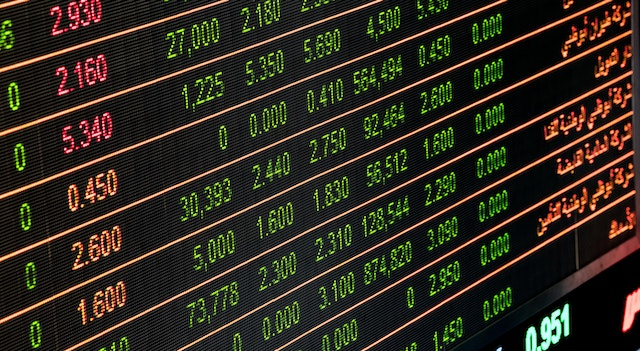

<font size="-1">Image Credit: <a href="https://www.pexels.com/es-es/foto/numeros-en-el-monitor-534216/"> Pixabay </a></font>


___
## **1. Goal**
___

The purpose of the present notebook is to define the components of the stock portofolio, retrieve the stocks value data by using the Yahoo Finance API, calculate the correspondent returns and optimize the portfolio composition to maximize the return.


___
## **2. Data Collection**
___

In [1]:
# Loading Requirements Text File
#!pip install -r requirements.txt

In [2]:
# Libraries installation
!pip install pip==21.2 # Pip version for successfully using the method get_installed_distributions
!pip install yfinance # Python API for retrieving stock data from Yahoo Finance
!pip install cvxopt # Convex Solver for portfolio optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
Reason for being yanked: See https://github.com/pypa/pip/issues/8711
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 92 kB/s 
     |████████████████████████████████| 128

In [3]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import yfinance as yf
import cvxopt as opt
from cvxopt import blas, solvers
from IPython.display import set_matplotlib_formats
from pip._internal.utils.misc import get_installed_distributions
import sys

In [4]:
# Setting theme and plot resolution
sns.set_theme(context = 'notebook', style = 'darkgrid')
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
set_matplotlib_formats('svg')

# Setting default plot's aesthetics
plotfontcolor = 'dimgray'
mpl.rcParams['text.color'] = plotfontcolor
mpl.rcParams['axes.labelcolor'] = plotfontcolor
mpl.rcParams['xtick.color'] = plotfontcolor
mpl.rcParams['ytick.color'] = plotfontcolor

For simplicity, in the present project, only 10 stocks selected from the biggest companies in the world by market capitalization <a href="https://www.investopedia.com/biggest-companies-in-the-world-by-market-cap-5212784">(Johnston, 2022)</a> were used to build the portfolio:
1. Apple Inc. (**AAPL**)
2. Saudi Aramco (**2222.SR**) 
3. Microsoft Corp. (**MSFT**)
4. Alphabet Inc. (**GOOGL**)
5. Amazon.com Inc. (**AMZN**)
6. Tesla Inc. (**TSLA**)
7. Berkshire Hathaway Inc. (**BRK-B**)
8. NVIDIA Corp. (**NVDA**)
9. Taiwan Semiconductor Manufacturing Co. Ltd. (**TSM**)
10. Meta Platforms Inc. (**META**)

On the other hand, stock value data was retrieved from the previous three years, i.e., **from 2020-01-01 to 2023-01-09**.

In [5]:
# List of companies whose stock data will be retrieved
stocks = ["AAPL", "2222.SR", "MSFT", "GOOGL", "AMZN", "TSLA", "BRK-B", "NVDA", "TSM", "META"]

# Retrieval of the Stock Data
df = yf.download(stocks, start="2020-01-01", end="2023-01-01")
df

[*********************100%***********************]  10 of 10 completed


Adj Close                                     \
                             2222.SR        AAPL       AMZN       BRK-B   
Date                                                                      
2019-12-31 21:00:00+00:00  25.947229         NaN        NaN         NaN   
2020-01-01 21:00:00+00:00  25.984190         NaN        NaN         NaN   
2020-01-02 05:00:00+00:00        NaN   73.561539  94.900497  228.389999   
2020-01-03 05:00:00+00:00        NaN   72.846390  93.748497  226.179993   
2020-01-04 21:00:00+00:00  25.540648         NaN        NaN         NaN   
...                              ...         ...        ...         ...   
2022-12-27 21:00:00+00:00  32.200001         NaN        NaN         NaN   
2022-12-28 05:00:00+00:00        NaN  126.040001  81.820000  303.429993   
2022-12-28 21:00:00+00:00  32.099998         NaN        NaN         NaN   
2022-12-29 05:00:00+00:00        NaN  129.610001  84.180000  309.059998   
2022-12-30 05:00:00+00:00        NaN  129.929993  84.000000  308.899994   

                                                                          \
                               GOOGL        META        MSFT        NVDA   
Date                                                                       
2019-12-31 21:00:00+00:00        NaN         NaN         NaN         NaN   
2020-01-01 21:00:00+00:00        NaN         NaN         NaN         NaN   
2020-01-02 05:00:00+00:00  68.433998  209.779999  156.151962   59.770561   
2020-01-03 05:00:00+00:00  68.075996  208.669998  154.207550   58.813866   
2020-01-04 21:00:00+00:00        NaN         NaN         NaN         NaN   
...                              ...         ...         ...         ...   
2022-12-27 21:00:00+00:00        NaN         NaN         NaN         NaN   
2022-12-28 05:00:00+00:00  86.019997  115.620003  234.529999  140.360001   
2022-12-28 21:00:00+00:00        NaN         NaN         NaN         NaN   
2022-12-29 05:00:00+00:00  88.449997  120.260002  241.009995  146.029999   
2022-12-30 05:00:00+00:00  88.230003  120.339996  239.820007  146.139999   

                                                  ...      Volume  \
                                 TSLA        TSM  ...     2222.SR   
Date                                              ...               
2019-12-31 21:00:00+00:00         NaN        NaN  ...   8517342.0   
2020-01-01 21:00:00+00:00         NaN        NaN  ...  11430744.0   
2020-01-02 05:00:00+00:00   28.684000  56.350285  ...         NaN   
2020-01-03 05:00:00+00:00   29.534000  54.491962  ...         NaN   
2020-01-04 21:00:00+00:00         NaN        NaN  ...  25239125.0   
...                               ...        ...  ...         ...   
2022-12-27 21:00:00+00:00         NaN        NaN  ...   3613685.0   
2022-12-28 05:00:00+00:00  112.709999  73.059998  ...         NaN   
2022-12-28 21:00:00+00:00         NaN        NaN  ...   5222624.0   
2022-12-29 05:00:00+00:00  121.820000  76.000000  ...         NaN   
2022-12-30 05:00:00+00:00  123.180000  74.489998  ...         NaN   

                                                                           \
                                  AAPL        AMZN      BRK-B       GOOGL   
Date                                                                        
2019-12-31 21:00:00+00:00          NaN         NaN        NaN         NaN   
2020-01-01 21:00:00+00:00          NaN         NaN        NaN         NaN   
2020-01-02 05:00:00+00:00  135480400.0  80580000.0  3764000.0  27278000.0   
2020-01-03 05:00:00+00:00  146322800.0  75288000.0  3023900.0  23408000.0   
2020-01-04 21:00:00+00:00          NaN         NaN        NaN         NaN   
...                                ...         ...        ...         ...   
2022-12-27 21:00:00+00:00          NaN         NaN        NaN         NaN   
2022-12-28 05:00:00+00:00   85438400.0  58228600.0  2628200.0  19523200.0   
2022-12-28 21:00:00+00:00          NaN         NaN        NaN         NaN   
2022-12-29 05:00:00+

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1505 entries, 2019-12-31 21:00:00+00:00 to 2022-12-30 05:00:00+00:00
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, 2222.SR)  749 non-null    float64
 1   (Adj Close, AAPL)     756 non-null    float64
 2   (Adj Close, AMZN)     756 non-null    float64
 3   (Adj Close, BRK-B)    756 non-null    float64
 4   (Adj Close, GOOGL)    756 non-null    float64
 5   (Adj Close, META)     756 non-null    float64
 6   (Adj Close, MSFT)     756 non-null    float64
 7   (Adj Close, NVDA)     756 non-null    float64
 8   (Adj Close, TSLA)     756 non-null    float64
 9   (Adj Close, TSM)      756 non-null    float64
 10  (Close, 2222.SR)      749 non-null    float64
 11  (Close, AAPL)         756 non-null    float64
 12  (Close, AMZN)         756 non-null    float64
 13  (Close, BRK-B)        756 non-null    float64
 14  (Close, GOOGL)        75

Only the Close value was considered in the further data analysis.

In [7]:
df = df.drop(columns = ['Adj Close', 'High', 'Low', 'Open', 'Volume'])
df.head()

Close                                    \
                             2222.SR       AAPL       AMZN       BRK-B   
Date                                                                     
2019-12-31 21:00:00+00:00  29.008265        NaN        NaN         NaN   
2020-01-01 21:00:00+00:00  29.049585        NaN        NaN         NaN   
2020-01-02 05:00:00+00:00        NaN  75.087502  94.900497  228.389999   
2020-01-03 05:00:00+00:00        NaN  74.357498  93.748497  226.179993   
2020-01-04 21:00:00+00:00  28.553719        NaN        NaN         NaN   

                                                                         \
                               GOOGL        META        MSFT       NVDA   
Date                                                                      
2019-12-31 21:00:00+00:00        NaN         NaN         NaN        NaN   
2020-01-01 21:00:00+00:00        NaN         NaN         NaN        NaN   
2020-01-02 05:00:00+00:00  68.433998  209.779999  160.619995  59.977501   
2020-01-03 05:00:00+00:00  68.075996  208.669998  158.619995  59.017502   
2020-01-04 21:00:00+00:00        NaN         NaN         NaN        NaN   

                                              
                             TSLA        TSM  
Date                                          
2019-12-31 21:00:00+00:00     NaN        NaN  
2020-01-01 21:00:00+00:00     NaN        NaN  
2020-01-02 05:00:00+00:00  28.684  60.040001  
2020-01-03 05:00:00+00:00  29.534  58.060001  
2020-01-04 21:00:00+00:00     NaN        NaN

In [8]:
# Remove of column upper name
df = df['Close']
df.head()

,2222.SR,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM
Date,,,,,,,,,,
2019-12-31 21:00:00+00:00,29.008265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 21:00:00+00:00,29.049585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 05:00:00+00:00,NaN,75.087502,94.900497,228.389999,68.433998,209.779999,160.619995,59.977501,28.684,60.040001
2020-01-03 05:00:00+00:00,NaN,74.357498,93.748497,226.179993,68.075996,208.669998,158.619995,59.017502,29.534,58.060001
2020-01-04 21:00:00+00:00,28.553719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


___
## **3. Data Exploration**
___

Stock value data retrieved from Yahoo Finance was explored through some simple visualizations.

In [9]:
def plot_stock_value(dataframe, stock_list):
    """
    Plots a list of stocks from a given dataframe of stocks values over time. Dates should be df's index.
    
    Parameters

    dataframe: A dataframe with dates id containing the close values 
               of a set of stocks over time. The columns are named after 
               the corresponding stocks codes according to the Yahoo ticker.

    stock_list: A list of strings of stock codes. They should coincide 
                with the columns names of the dataframe.

    Returns None
    """
       
    for i in stock_list:
        plt.figure(figsize = (8,5))
        sns.lineplot(data = dataframe, x = dataframe.index, y = i)
        plt.title(f'{i} Close Value Over Time', fontweight = 'bold', size = 14, color = plotfontcolor)
        plt.ylabel('Close Value (USD)', fontweight = 'bold', color = plotfontcolor)        
        plt.xlabel('Date', fontweight = 'bold', color = plotfontcolor)
        plt.xticks(rotation = 45, color = plotfontcolor)
        plt.show()

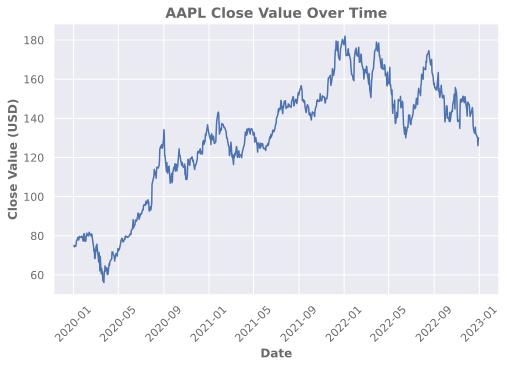

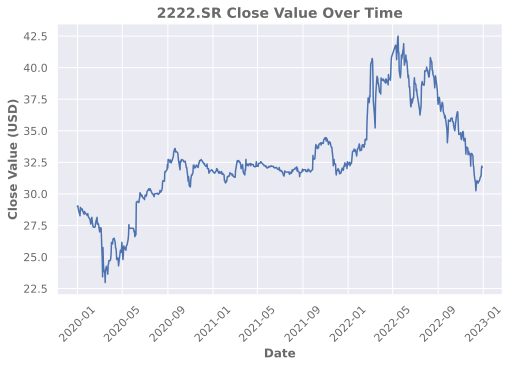

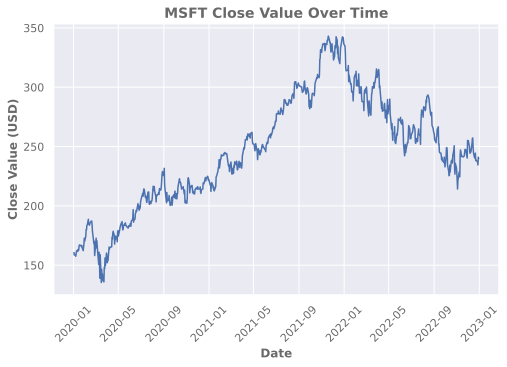

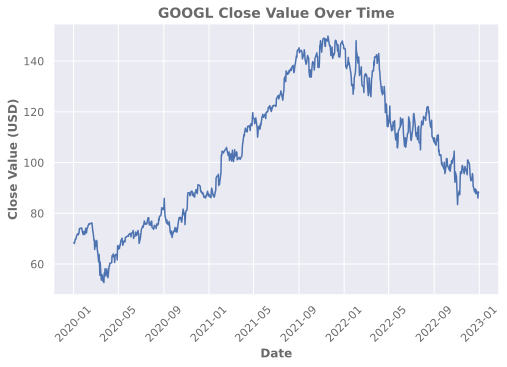

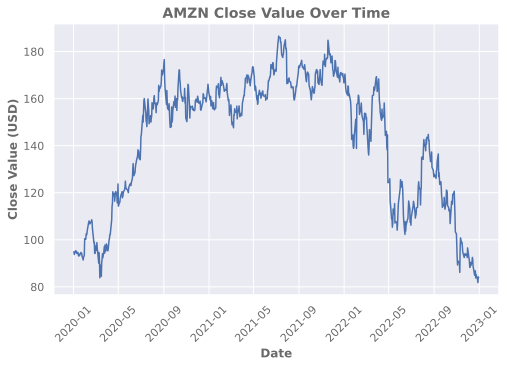

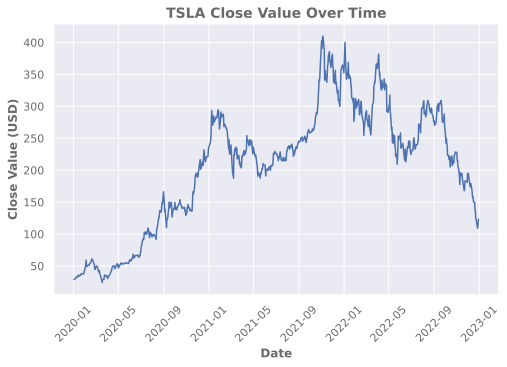

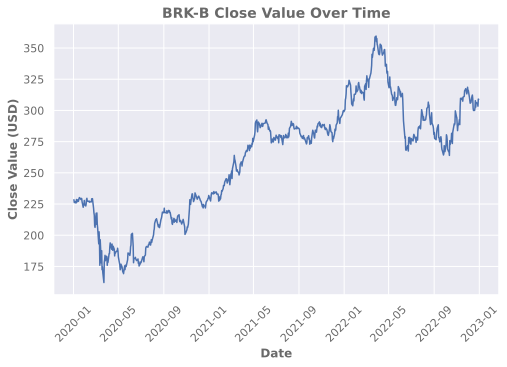

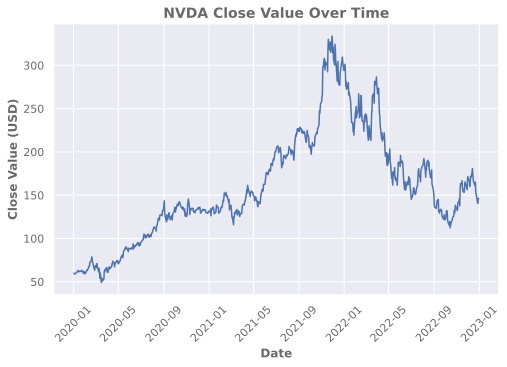

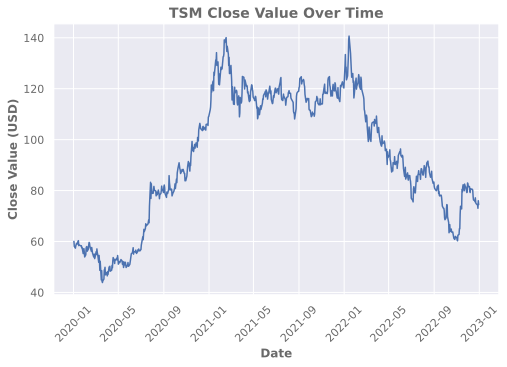

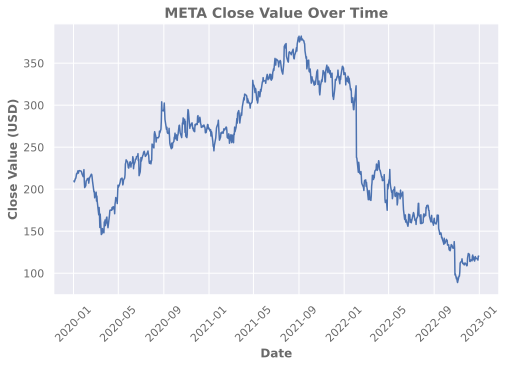

In [10]:
plot_stock_value(df, stocks)

The EDA suggests that **the market has been bearish since mids 2021**. At the end of 2022 and begining of 2023, all stocks but BRK-B have decreased their value to the 2020 levels.

Notwithstanding the above, the data collected from *Yahoo Finance* through **yfinance** seems to be complete and consistent.

___
## **4. Data Preparation**
___

Stock data value was cleaned and processed to calculate the **daily returns** which serves as a basis for the portfolio optimization.

#### **4.1 Data Cleaning**

The stock data from Saudi Aramco (2222.SR) is one day off from the rest of the stocks in the portfolio. For sake of consistency and simplicity, the close values of 2222.SR were aligned with the rest of stocks.

In [11]:
# Storing Saudi Aramco Close Values into a list
SA = list(df['2222.SR'])
print(SA[:5])
print(SA[-5:-1])

[29.008264541625977, 29.049585342407227, nan, nan, 28.55371856689453]
[32.20000076293945, nan, 32.099998474121094, nan]


In [12]:
# Adding a NaN value at the beginning of the list and removing list's last value
SA.insert(0, np.nan)
SA = SA[:-1]
print(SA[:5])
print(SA[-5:-1])

[nan, 29.008264541625977, 29.049585342407227, nan, nan]
[nan, 32.20000076293945, nan, 32.099998474121094]


In [13]:
# Creating new 2222.SR_ colum with the adjusted Saudi Aramco values and drop of the original column
df['2222.SR_'] = SA
df = df.drop(columns = '2222.SR').rename(columns = {'2222.SR_': '2222.SR'})
df.head()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
Date,,,,,,,,,,
2019-12-31 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.008265
2020-01-02 05:00:00+00:00,75.087502,94.900497,228.389999,68.433998,209.779999,160.619995,59.977501,28.684,60.040001,29.049585
2020-01-03 05:00:00+00:00,74.357498,93.748497,226.179993,68.075996,208.669998,158.619995,59.017502,29.534,58.060001,NaN
2020-01-04 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Removal of null values
df = df.dropna()
df.head()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
Date,,,,,,,,,,
2020-01-02 05:00:00+00:00,75.087502,94.900497,228.389999,68.433998,209.779999,160.619995,59.977501,28.684000,60.040001,29.049585
2020-01-06 05:00:00+00:00,74.949997,95.143997,226.990005,69.890503,212.600006,159.029999,59.264999,30.102667,57.389999,28.512396
2020-01-07 05:00:00+00:00,74.597504,95.343002,225.919998,69.755501,213.059998,157.580002,59.982498,31.270666,58.320000,28.388430
2020-01-08 05:00:00+00:00,75.797501,94.598503,225.990005,70.251999,215.220001,160.089996,60.095001,32.809334,58.750000,28.264462
2020-01-09 05:00:00+00:00,77.407501,95.052498,228.649994,70.989502,218.300003,162.089996,60.755001,32.089333,59.230000,28.925619


In [15]:
# Converting the stock values to a tidy dataframe
stock_values_tidy = pd.melt(df.reset_index(), id_vars = 'Date', var_name = 'Stock', value_name = 'CloseValue')
stock_values_tidy.head()

,Date,Stock,CloseValue
0,2020-01-02 05:00:00+00:00,AAPL,75.087502
1,2020-01-06 05:00:00+00:00,AAPL,74.949997
2,2020-01-07 05:00:00+00:00,AAPL,74.597504
3,2020-01-08 05:00:00+00:00,AAPL,75.797501
4,2020-01-09 05:00:00+00:00,AAPL,77.407501


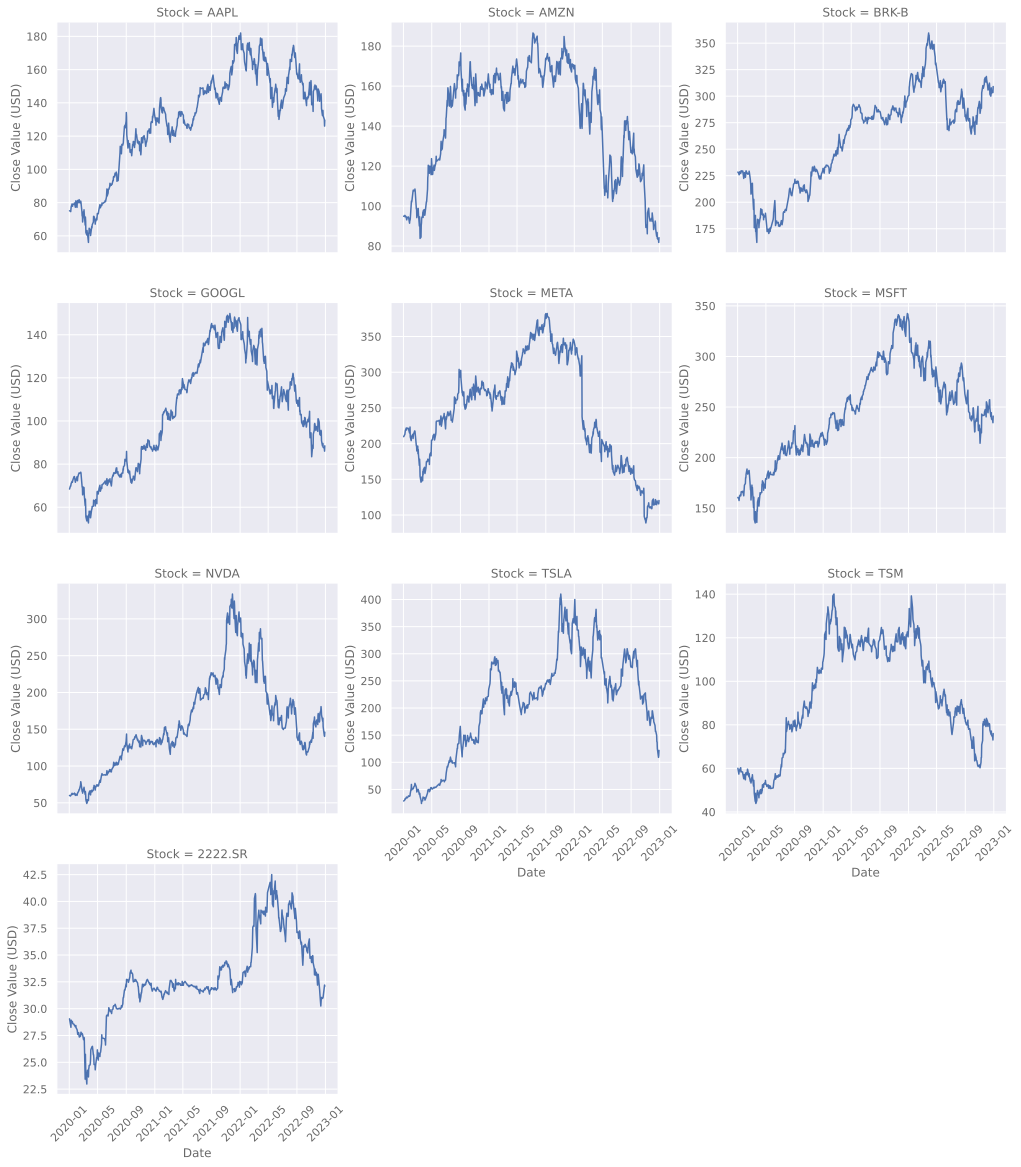

In [16]:
# Plot of the historical stock values
g = sns.relplot(data = stock_values_tidy, 
            x = 'Date', 
            y = 'CloseValue', col = 'Stock',
            col_wrap = 3,  kind='line', 
            height = 4, aspect = 1.2,
            facet_kws={'sharey': False, 'sharex': True}
            )
for ax in g.axes.flat:
    ax.set_ylabel('Close Value (USD)', color = plotfontcolor)
    ax.set_xlabel('Date', color = plotfontcolor)    
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation = 45, color = plotfontcolor)
    ylabels = ax.get_yticklabels()
    ax.set_yticklabels(ylabels, color = plotfontcolor)

plt.savefig('Fig1_HistStockCloseValues.png',  bbox_inches = 'tight')
plt.show()

#### **4.2 Calculation of the Daily Returns**

Based of the close value for each stock, the daily returns were calculated. To do so a function for getting the daily returns was defined.

In [17]:
# Function to get daily returns

def get_daily_returns(series):
    """
    Returns a list of daily returns of a pandas series of stock data values.
    
    Parameters

    series: A pandas series of daily stock close values.

    Returns 

    returns: A list of daily returns.


    """
    returns = []
    stock_values = list(series)

    for i in range(1, len(stock_values)):
        try:
            return_i = (stock_values[i + 1] - stock_values[i]) / stock_values[i]
            returns.append(return_i)
        except:
            pass

    return returns

In [18]:
# Getting daily returns for each stock and creating a new returns dataframe
AAPL_r = get_daily_returns(df['AAPL'])
AMZN_r = get_daily_returns(df['AMZN'])
BRKB_r = get_daily_returns(df['BRK-B'])
GOOGL_r = get_daily_returns(df['GOOGL'])
META_r = get_daily_returns(df['META'])
MSFT_r = get_daily_returns(df['MSFT'])
NVDA_r = get_daily_returns(df['NVDA'])
TSLA_r = get_daily_returns(df['TSLA'])
TSM_r = get_daily_returns(df['TSM'])
SR_r = get_daily_returns(df['2222.SR'])

returns_df = pd.DataFrame(
    {'AAPL': AAPL_r,
     'AMZN': AMZN_r,
     'BRK-B': BRKB_r,
     'GOOGL': GOOGL_r,
     'META': META_r,
     'MSFT': MSFT_r,
     'NVDA': NVDA_r,
     'TSLA': TSLA_r,
     'TSM': TSM_r,
     '2222.SR': SR_r
    })

returns_df.index = df.index[1:-1] # Dropping first and last date values
returns_df.head()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
Date,,,,,,,,,,
2020-01-06 05:00:00+00:00,-0.004703,0.002092,-0.004714,-0.001932,0.002164,-0.009118,0.012107,0.038801,0.016205,-0.004348
2020-01-07 05:00:00+00:00,0.016086,-0.007809,0.000310,0.007118,0.010138,0.015928,0.001876,0.049205,0.007373,-0.004367
2020-01-08 05:00:00+00:00,0.021241,0.004799,0.011770,0.010498,0.014311,0.012493,0.010983,-0.021945,0.008170,0.023392
2020-01-09 05:00:00+00:00,0.023673,-0.005129,-0.000875,0.014256,0.016537,0.007342,0.036869,0.090414,0.014013,-0.007143
2020-01-13 05:00:00+00:00,-0.013503,-0.011558,-0.005603,-0.006555,-0.012843,-0.007043,-0.018652,0.024883,0.004329,0.002878


In [19]:
returns_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 582 entries, 2020-01-06 05:00:00+00:00 to 2022-12-28 05:00:00+00:00
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AAPL     582 non-null    float64
 1   AMZN     582 non-null    float64
 2   BRK-B    582 non-null    float64
 3   GOOGL    582 non-null    float64
 4   META     582 non-null    float64
 5   MSFT     582 non-null    float64
 6   NVDA     582 non-null    float64
 7   TSLA     582 non-null    float64
 8   TSM      582 non-null    float64
 9   2222.SR  582 non-null    float64
dtypes: float64(10)
memory usage: 50.0 KB


In [20]:
returns_df.describe()

,AAPL,AMZN,BRK-B,GOOGL,META,MSFT,NVDA,TSLA,TSM,2222.SR
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,0.001279,0.000227,0.000687,0.000679,-0.000380,0.000993,0.002347,0.003701,0.000885,0.000317
std,0.026089,0.029300,0.017659,0.023432,0.034001,0.023576,0.039920,0.050988,0.028604,0.015015
min,-0.098755,-0.247637,-0.095921,-0.091405,-0.263901,-0.094838,-0.143160,-0.206012,-0.092939,-0.140909
25%,-0.011806,-0.014361,-0.007138,-0.010837,-0.016453,-0.009842,-0.019207,-0.024898,-0.015944,-0.004342
50%,0.000296,0.001291,0.001435,0.000930,-0.000146,0.001388,0.003166,0.002986,0.000042,0.000000
75%,0.016198,0.014336,0.008762,0.013385,0.016533,0.014315,0.025370,0.028880,0.015563,0.004361
max,0.180263,0.137491,0.099118,0.088910,0.175936,0.092363,0.171564,0.217209,0.235713,0.101708


**TSLA** had the **highest average return** (0.292%); whereas **META** has **the lowest one** (-0.014%) in the analyzed time period.

On the other hand, **TSLA** also exhibited the **largest volatility** (4.633%); whereas **2222.SR** exhibited **the lowest one** (1.275%).

Thus, even though the **TSLA** has yielded the highest average return in the last three years, it comes with a high risk. In this sense, the Beta of this company is 2.03 according to <a href="https://finance.yahoo.com/quote/TSLA?p=TSLA&.tsrc=fin-srch">Yahoo Finance</a>, which means that TSLA overreacts to the changes in the market.

In [21]:
# Converting returns_df into a tidy format
returns_tidy_df = pd.melt(frame = returns_df, var_name = 'Stock', value_name = 'DailyReturn', ignore_index = False)
returns_tidy_df.head()

,Stock,DailyReturn
Date,,
2020-01-06 05:00:00+00:00,AAPL,-0.004703
2020-01-07 05:00:00+00:00,AAPL,0.016086
2020-01-08 05:00:00+00:00,AAPL,0.021241
2020-01-09 05:00:00+00:00,AAPL,0.023673
2020-01-13 05:00:00+00:00,AAPL,-0.013503


In [22]:
returns_tidy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5820 entries, 2020-01-06 05:00:00+00:00 to 2022-12-28 05:00:00+00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Stock        5820 non-null   object 
 1   DailyReturn  5820 non-null   float64
dtypes: float64(1), object(1)
memory usage: 136.4+ KB


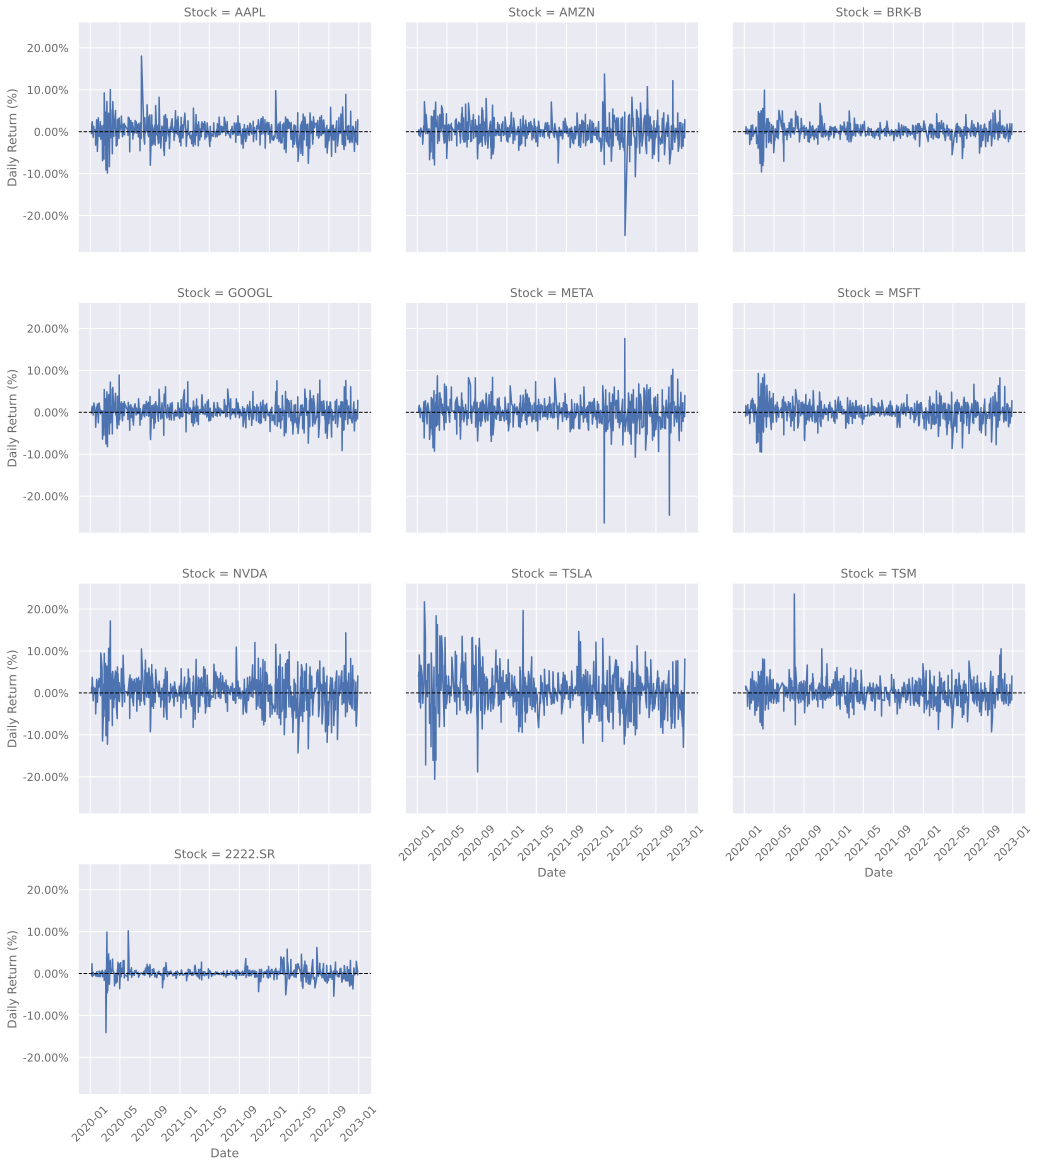

In [23]:
# Visualizing the daily returns for each stock
g = sns.relplot(data = returns_tidy_df, 
            x = returns_tidy_df.index, 
            y = 'DailyReturn', col = 'Stock',
            col_wrap = 3,  kind='line', 
            height = 4, aspect = 1.2,
            facet_kws={'sharey': True, 'sharex': True}
            )
for ax in g.axes.flat:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    ax.set_ylabel('Daily Return (%)', color = plotfontcolor)
    ax.set_xlabel('Date', color = plotfontcolor)
    ax.axhline(y = 0, color = 'black', linewidth = 1, linestyle = '--')
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation = 45, color = plotfontcolor)
    ylabels = ax.get_yticklabels()
    ax.set_yticklabels(ylabels, color = plotfontcolor)

plt.savefig('Fig2_HistStockReturns.png',  bbox_inches = 'tight')
plt.show()

From the figures above, **TSLA** and **NVDA** daily returns are **the most volatile**; whereas the **2222.SR** and **BRK-B** ones are **the less**.

#### **4.3 Optimization of the Stocks Portfolio**

Once the daily returns were calculated, the weight of each stock was optimized in the portfolio to maximize the return thereof using Convex optimization. This part of the analysis is based on <a href="https://github.com/quantopian/research_public/blob/master/research/Markowitz-blog.ipynb">Starke, Edwards & Wiecki (2016)</a>.

In [24]:
# Turn off progress printing 
solvers.options['show_progress'] = False

In [25]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio.

    Parameters

    returns: Numpy array of the daily returns (rows) of a set of stocks (columns).    

    Returns

    mu: Scalar number with the expected return (mean) of the random portfolio.

    sigma: Scalar number with the volatility (standard deviation) of the random 
           portfolio.

    '''
    returns = returns.T
    
    # Number of assets/instruments
    n = returns.shape[0]
    
    # Produces n random weights that sum to 1 
    k = np.random.rand(n)
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(k / sum(k))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [26]:
def optimal_portfolio(returns, portfolios):
    """
    Optimization of a portfolio's expected return by minimizing overall instrument's risks.

    Parameters

    returns: Numpy array of the daily returns (rows) of a set of stocks (columns).

    portfolios: Number of portfolios to create to enable the optimization process.

    Returns

    weights: Numpy array with the optimized weights of the instruments of the 
             stocks porfolio.

    returns: List with the portfolios' expected returns.

    risks: List with the portfolios' estimated volatilities.

    """
    returns = returns.T
    n = returns.shape[0] # Number of assets/instruments
    
    N = portfolios
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    weights = np.asarray(wt)
    
    return weights, returns, risks

In [27]:
# Defining Historical Returns Array
hist_returns = returns_df.values
#returns = np.random.randn(10, 1000).T # Random returns

In [28]:
# Creation of 300 random portfolios
n_portfolios = 300
means, stds = np.column_stack([
    random_portfolio(hist_returns) 
    for n_portfolio in range(n_portfolios)
])

In [29]:
# Optimization of the stocks portfolio based on the historical daily returns
weights, returns, risks = optimal_portfolio(hist_returns, 100)

<ipython-input-30-dc595b487daa>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(111)


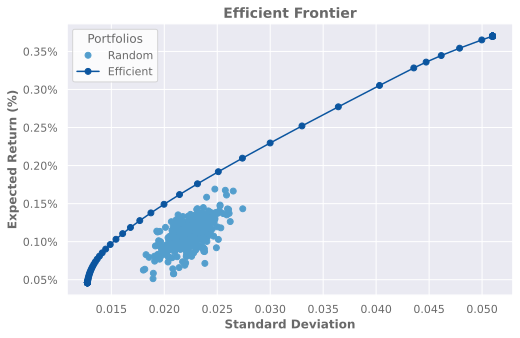

In [30]:
# Plot of the Efficient Frontier ("Markowitz bullet")
fig = plt.figure(figsize = (8,5))
ax1 = fig.add_subplot(111)
randport = ax1.plot(stds, means, 'o',  color = sns.color_palette('Blues_r')[2], label='Random')
ax2 = fig.add_subplot(111)
effport = ax2.plot(risks, returns, marker = 'o', color = sns.color_palette('Blues_r')[0], label='Efficient')
plt.title('Efficient Frontier', fontweight = 'bold', color = plotfontcolor, size = 14)
plt.ylabel('Expected Return (%)', fontweight = 'bold', color = plotfontcolor)
plt.xlabel('Standard Deviation', fontweight = 'bold', color = plotfontcolor)
plt.legend(title = 'Portfolios', facecolor = 'w')
plt.xticks(color = plotfontcolor)
plt.yticks(color = plotfontcolor)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.savefig('Fig3_EfficientFrontier.png',  bbox_inches = 'tight')
plt.show()

In [31]:
# Optimal Portfolio
weights_list = [i[0] for i in weights]
weights_list

[4.176503890124486e-07,
 3.42401914135224e-07,
 3.8010317793421377e-07,
 3.79390042070708e-07,
 2.972443866866898e-07,
 4.030121166416229e-07,
 7.036073698066433e-08,
 0.9999969646578027,
 3.9532204268348737e-07,
 3.498573911281196e-07]

In [32]:
stocks_list = [i for i in returns_df.columns]
stocks_list

['AAPL',
 'AMZN',
 'BRK-B',
 'GOOGL',
 'META',
 'MSFT',
 'NVDA',
 'TSLA',
 'TSM',
 '2222.SR']

In [33]:
weights_df = pd.DataFrame(zip(*[returns_df.columns,weights_list])).rename(columns = {0: 'Stock', 1:'Weight'})
weights_df

,Stock,Weight
0,AAPL,4.176504e-07
1,AMZN,3.424019e-07
2,BRK-B,3.801032e-07
3,GOOGL,3.793900e-07
4,META,2.972444e-07
5,MSFT,4.030121e-07
6,NVDA,7.036074e-08
7,TSLA,9.999970e-01
8,TSM,3.953220e-07
9,2222.SR,3.498574e-07


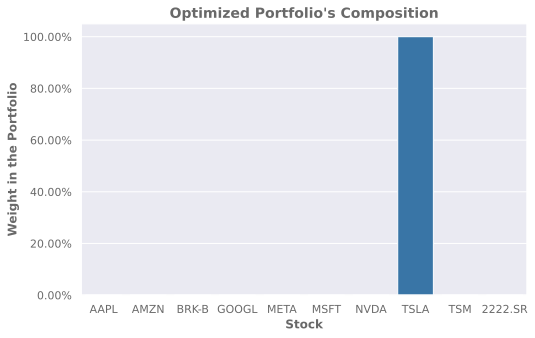

In [34]:
plt.figure(figsize = (8,5))
ax = sns.barplot(data = weights_df, x = 'Stock', y = 'Weight', palette = 'Blues')
plt.title("Optimized Portfolio's Composition", fontweight = 'bold', color = plotfontcolor, size = 14)
plt.ylabel('Weight in the Portfolio', fontweight = 'bold', color = plotfontcolor)
plt.xlabel('Stock', fontweight = 'bold', color = plotfontcolor)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.xticks(color = plotfontcolor)
plt.yticks(color = plotfontcolor)
plt.savefig('Fig4_PortfolioComposition.png',  bbox_inches = 'tight')
plt.show()

Interestingly, the portfolio optimization yielded that most of the portfolio should be TSLA stocks (about 99%). 

Even though these results contradicts the idea of having a diversified portfolio, for the purposes of the present analysis the outcome from the optimization algorithm were used in the later steps of this project.

#### **4.4 Historical Returns of the Optimized Portfolio**

After the portfolio was optimized, the historical returns thereof were calculated based on the stock close value over time and the optimized weights.

In [35]:
# Calculation of Historical Returns of the Optimized Portfolio
optimized_returns = np.matrix(returns_df.values) * weights
optimized_returns[:10]

matrix([[ 0.03880041],
        [ 0.04920469],
        [-0.0219449 ],
        [ 0.090414  ],
        [ 0.02488273],
        [-0.03610191],
        [-0.00966242],
        [ 0.06564861],
        [ 0.04086252],
        [ 0.0046351 ]])

In [36]:
# Historical Returns of the Optimized Portfolio Dataframe
optimized_returns_list = [i[0] for i in np.array(optimized_returns)]
optimized_returns_df = pd.DataFrame((optimized_returns_list)).rename(columns = {0: 'Returns'})
optimized_returns_df.index = returns_df.index
optimized_returns_df.head()

,Returns
Date,
2020-01-06 05:00:00+00:00,0.038800
2020-01-07 05:00:00+00:00,0.049205
2020-01-08 05:00:00+00:00,-0.021945
2020-01-09 05:00:00+00:00,0.090414
2020-01-13 05:00:00+00:00,0.024883


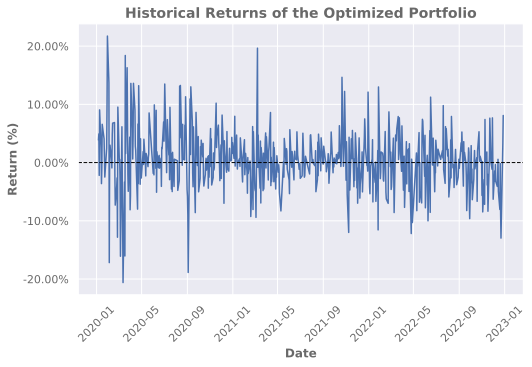

In [37]:
# Plot of the Historical Returns of the Optimized Portfolio
plt.figure(figsize = (8,5))
ax = sns.lineplot(data = optimized_returns_df, x = optimized_returns_df.index, y = 'Returns')
plt.title("Historical Returns of the Optimized Portfolio", fontweight = 'bold', color = plotfontcolor, size = 14)
plt.ylabel('Return (%)', fontweight = 'bold', color = plotfontcolor)
plt.xlabel('Date', fontweight = 'bold', color = plotfontcolor)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax.axhline(y = 0, color = 'black', linewidth = 1, linestyle = '--')
plt.xticks(rotation = 45, color = plotfontcolor)
plt.yticks(color = plotfontcolor)
plt.savefig('Fig5_HistReturnsOptPort.png',  bbox_inches = 'tight')
plt.show()

As expectable, the historical returns of the optimized portfolio mirror the behavior of **TSLA** as most of the portfolio comprises such asset.

In [38]:
# Exportation of the Historical Returns of the Optimized Portfolio 
optimized_returns_df.to_csv("Hist_Opt_Returns.csv", index = True)

In addition to the above, the **value of the optimized portfolio** was also calculated by calculating the product of the values of each instrument with their optimized weights.

In [41]:
# Calculation of Historical Values of the Optimized Portfolio
optimized_values = np.matrix(df.values) * weights
optimized_values[:10]

matrix([[28.68425479],
        [30.10291628],
        [31.27091139],
        [32.80957665],
        [32.08958192],
        [34.99090884],
        [35.86156995],
        [34.56690815],
        [34.2329125 ],
        [36.48023958]])

In [43]:
# Historical Values of the Optimized Portfolio Dataframe
optimized_values_list = [i[0] for i in np.array(optimized_values)]
optimized_values_df = pd.DataFrame((optimized_values_list)).rename(columns = {0: 'CloseValue'})
optimized_values_df.index = df.index
optimized_values_df.head()

,CloseValue
Date,
2020-01-02 05:00:00+00:00,28.684255
2020-01-06 05:00:00+00:00,30.102916
2020-01-07 05:00:00+00:00,31.270911
2020-01-08 05:00:00+00:00,32.809577
2020-01-09 05:00:00+00:00,32.089582


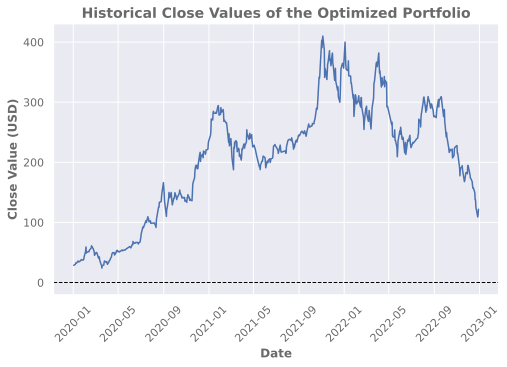

In [44]:
# Plot of the Historical Close Values of the Optimized Portfolio
plt.figure(figsize = (8,5))
ax = sns.lineplot(data = optimized_values_df, x = optimized_values_df.index, y = 'CloseValue')
plt.title("Historical Close Values of the Optimized Portfolio", fontweight = 'bold', color = plotfontcolor, size = 14)
plt.ylabel('Close Value (USD)', fontweight = 'bold', color = plotfontcolor)
plt.xlabel('Date', fontweight = 'bold', color = plotfontcolor)
ax.axhline(y = 0, color = 'black', linewidth = 1, linestyle = '--')
plt.xticks(rotation = 45, color = plotfontcolor)
plt.yticks(color = plotfontcolor)
plt.savefig('Fig6_HistValuesOptPort.png',  bbox_inches = 'tight')
plt.show()

As expectable, the historical values of the optimized portfolio mimic the performance of **TSLA** as most of the portfolio comprises such instrument.

In [45]:
# Exportation of the Historical Close Values of the Optimized Portfolio 
optimized_values_df.to_csv("Hist_Opt_Values.csv", index = True)

Python Requirements File:

In [39]:
# Code for composing the Python Requirements File

def get_imported_packages():
    """
    Function to get imported packages to current notebook.

    Parameters

    None

    Returns

    modules: List of imported packages
    """
    p = get_installed_distributions()
    p = {package.key:package.version for package in p}

    imported_modules = set(sys.modules.keys())
    
    #imported_modules.remove('pip')

    modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

    return modules


def generate_requirements(filepath:str, modules):
    """
    Function to print a set of packages into a text file.

    Parameters

    filepath: String with the name of the output text file 
    modules: List of the packages to be printed in the output text file

    Returns

    None
    """
    with open(filepath, 'w') as f:
        for module, version in modules:
            f.write(f"{module}=={version}\n")


generate_requirements('requirements.txt', get_imported_packages())

In [40]:
# End